In [1]:
%cd ..

C:\cygwin64\home\evger\thesis


In [2]:
import glob
import os
import datetime
import random

from collections import deque, namedtuple, defaultdict
from typing import Union, List, Dict, Tuple, NamedTuple, Deque, Optional

import pandas as pd
import numpy as np

In [3]:
from hft.utils import logger
logger.to_file = True
logger.fmt_string = "%(message)s"

from hft.backtesting.backtest import BacktestOnSample
from hft.backtesting.data import OrderStatus, OrderRequest
from hft.backtesting.readers import OrderbookReader
from hft.backtesting.strategy import Strategy
from hft.units.metrics.composite import Lipton
from hft.units.metrics.instant import VWAP_volume, LiquiditySpectrum, HayashiYoshido
from hft.units.metrics.time import TradeMetric
from hft.utils.data import Trade, OrderBook
from hft.backtesting.output import make_plot_orderbook_trade, Output, SimulatedOrdersOutput

## Dueling DQN 

Dueling DQN implementation with target network implementation on pytorch.  

In [4]:
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DuelingDQN(nn.Module):
  def __init__(self, input_dim: int, output_dim: int):
    super().__init__()
    self.input_dim: int = input_dim
    self.output_dim: int = output_dim

    self.feature_layer = nn.Sequential(
      nn.Linear(input_dim, 128),
      nn.LayerNorm(128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.LayerNorm(128),
      nn.ReLU()
    )

    self.value_stream = nn.Sequential(
      nn.Linear(128, 128),
      nn.LayerNorm(128),
      nn.ReLU(),
      nn.Linear(128, 1)
    )

    self.advantage_stream = nn.Sequential(
      nn.Linear(128, 128),
      nn.LayerNorm(128),
      nn.ReLU(),
      nn.Linear(128, self.output_dim)
    )

  def forward(self, x):
    x = self.feature_layer(x)
    value = self.value_stream(x)
    adv = self.advantage_stream(x)
    qvals = value + (adv - adv.mean())
    return value, adv, qvals

## Decision condition

Class defines moments when model will make actions.  
Model's reaction on __each__ snapshot update would be incredibly expensive, thus it reacts _volume-based_.  

## Agent

Class stores inner operation for RL:

- Stores _replay buffer_  
- Generates actions via model or random  
- Evaluates rewards and updates models  

In [5]:
State = namedtuple('State', 'prev_obs prev_ps action obs ps meta done')

class DecisionCondition:
  def __init__(self, volume: float):
    self.volume_condition: float = volume
    self.reset()

  def __call__(self, is_trade: bool, event: Union[Trade, OrderBook]):
    if is_trade and event.symbol == 'XBTUSD':
      self.volume += event.volume
      if self.volume > self.volume_condition:
        self.volume %= self.volume_condition
        return True
    return False

  def reset(self):
    self.volume = 0.0

class Agent:
  def __init__(self, model: DuelingDQN, target: DuelingDQN,
               condition: DecisionCondition,
               gamma = 0.99, lr=1e-3,
               update_each:int=4,
               buffer_size:int=30000, batch_size=1024):
    self._replay_buffer: Deque[State] = deque(maxlen=buffer_size)
    self._batch_size: int = batch_size
    self.condition: DecisionCondition = condition
    self._model : DuelingDQN = model
    self._target: DuelingDQN = target
    self.end_episode_states: List = []
    self.episode_files: List[Tuple[str, str]] = []

    self.EPS_START = 0.9
    self.EPS_END = 0.1
    self.EPS_DECAY = 400


    self.gamma = gamma
    self.MSE_loss = torch.nn.MSELoss()
    self.optimizer = torch.optim.RMSprop(self._model.parameters(), lr=lr)

    self._update_each = update_each
    self.episode_counter = 0
    self.reset_state()

  def episode_results(self) -> pd.DataFrame:
    fnames, states = agent.episode_files, agent.end_episode_states
    states = [t[0].tolist() + [t[1]] for t in states]
    episodes = [list(t[0]) + t[1] for t in zip(fnames, states)]
    res = pd.DataFrame(episodes, columns=['ob_file', 'tr_file', 'usd', 'xbt', 'eth', 'xbt_price'])
    return res

  def reset_state(self):
    self.obs = None
    self.action = None
    self.ps = None
    self.episode_counter += 1
    self.condition.reset()

    # reload weights
    if (self.episode_counter + 1) % self._update_each == 0:
      state = self._model.state_dict()
      self._target.load_state_dict(state)
      torch.save(state, 'model.pth')

  def get_reward(self, prev_v: torch.Tensor, v: torch.Tensor,
                 prev_ps: torch.Tensor, ps: torch.Tensor,
                 tau: torch.Tensor, a=0.35, b=1./1000):
    vv = a * (v - prev_v)
    vv.squeeze_(1)

    state_delta = torch.abs(prev_ps) - torch.abs(ps) # todo: updated here, react negatively on accumulation of assets
    pos = (torch.exp(b*tau) * state_delta) # todo: updated here, instead of sign, use delta

    # a(V_t - V_{t-1}) + e^{b*tau} * sgn(|i_t| - |i_{t-1}|)
    return vv + pos

  def get_terminal_reward(self, terminal_ps, terminal_prices, alpha=3.0):
    return alpha - torch.exp(-(terminal_ps[:, 0] / terminal_prices - terminal_ps[:, 1])) # 0: usd, 1: xbtusd, 2: ethusd

  def store_episode(self, new_obs, new_ps, meta, done, action):
    if self.is_initialized():
      self._replay_buffer.append((self.obs, self.ps, self.action, new_obs, new_ps, meta, done))
    self.obs = new_obs
    self.ps = new_ps
    self.action = action

  def is_initialized(self):
    return self.obs is not None  # happens after reset, first obs is missing

  def get_action(self, obs):
    eps = self.EPS_END + (self.EPS_START - self.EPS_END) * np.exp(-1. * self.episode_counter / self.EPS_DECAY)
    if np.random.uniform(0.0, 1.0) < eps:
      return random.randint(0, self._model.output_dim - 1)
    with torch.no_grad():
      _, _, qvals = self._target(torch.tensor(obs, dtype=torch.float).unsqueeze(0))
      action = torch.argmax(qvals).cpu().detach().item()
      return action

  def update(self):
    if len(self._replay_buffer) > self._batch_size:
      items = random.sample(self._replay_buffer, self._batch_size)
      prev_obs, prev_ps, action, obs, ps, meta, done = zip(*items)
      prev_obs, prev_ps, obs, ps, meta = map(lambda x: torch.tensor(x, dtype=torch.float), [prev_obs, prev_ps, obs, ps, meta])
      done = torch.tensor(done, dtype=torch.bool)
      action = torch.tensor(action, dtype=torch.long).unsqueeze(1)

      v, _, qvalues = self._model(prev_obs)
      next_v, _, next_qvalues = self._target(obs)

      rewards = torch.empty_like(done, dtype=torch.float)
      rewards[done] = self.get_terminal_reward(ps[done], meta[done][:, 0])
      rewards[~done] = self.get_reward(v[~done], next_v[~done], prev_ps[~done][:, 1], ps[~done][:, 1], meta[~done][:, 1])
      rewards.clamp_(-1., 1.) # reward clipping


      qvalues = qvalues.gather(1, action).squeeze(1)
      next_qvalues = next_qvalues.max(1)[0]
      expected_q = rewards + (1 - done) * self.gamma * next_qvalues

      loss = self.MSE_loss(qvalues, expected_q)  # or hubert loss

      self.optimizer.zero_grad()
      loss.backward()
      for param in self._model.parameters():
        param.grad.data.clamp_(-1., 1.) # gradient clipping
      self.optimizer.step()

## RL Strategy

Class wrapper for RL operations: 

- Provides observations, portfolio states
- Transforms action space into orders
- Communicates with backtest

In [6]:
class RLStrategy(Strategy):
  def __init__(self, agent: Agent, simulation_end: datetime.datetime, **kwags):
    super().__init__(**kwags)
    self.agent: Agent = agent
    self._simulation_end = simulation_end
    self.action_space: Dict[int, Tuple[int, int]] = {
      0: (0, 0),
      1: (1, 0),
      2: (2, 0),
      3: (3, 0),
      4: (1, 0),
      5: (1, 1),
      6: (1, 2),
      7: (1, 3),
      8: (2, 0),
      9: (2, 1),
      10: (2, 2),
      11: (2, 3),
      12: (3, 0),
      13: (3, 1),
      14: (3, 2),
      15: (3, 3),
      16: (-1, -1)
    }

  def return_unfinished(self, statuses: List[OrderStatus], memory: Dict[str, Union[Trade, OrderBook]]):
    obs, ps, prices = self.get_observation(memory)
    meta = (prices, 0.0)
    self.agent.store_episode(obs, ps, meta, True, None)
    self.agent.end_episode_states.append((ps, meta[0])) # end state and prices
    self.agent.reset_state()

    super().return_unfinished(statuses, memory)

  def get_observation(self, memory):
    items = list(map(lambda name: self.metrics_map[name].to_numpy(), names + time_names))
    items = [t.flatten() for t in items]

    prices = self.get_prices(memory)
    ps = self.get_state()
    state = np.array([ps[0] / prices, ps[1]])

    items += [state]
    items = np.concatenate(items, axis=None)
    return items, ps, prices

  def get_prices(self, memory) -> float: # todo: refactor and use vwap
    xbt: OrderBook = memory[('orderbook', 'XBTUSD')]
    xbt_midprice = (xbt.ask_prices[0] + xbt.bid_prices[0]) / 2

    # eth: OrderBook = memory[('orderbook', 'ETHUSD')]
    # eth_midprice = (eth.ask_prices[0] + eth.bid_prices[0]) / 2

    return xbt_midprice

  def get_state(self) -> np.array:
    return np.array(list(self.balance.values()))

  def get_timeleft(self, ts: datetime.datetime) -> float:
    return (self._simulation_end - ts).total_seconds()

  def action_to_order(self, action: int, memory, ts, quantity: int) -> List[OrderRequest]: # value from 0 to 8
    if action == 16: # `do nothing` action
        return []
    offset_bid, offset_ask = self.action_space[action]

    offset_bid *= 0.5 # price step is .5 dollars
    offset_ask *= 0.5

    ob: OrderBook = memory[('orderbook', 'XBTUSD')]

    return [OrderRequest.create_bid(ob.bid_prices[0] - offset_bid, quantity, 'XBTUSD', ts),
            OrderRequest.create_ask(ob.ask_prices[0] + offset_ask, quantity, 'XBTUSD', ts)]

  def define_orders(self, row: Union[Trade, OrderBook],
                    statuses: List[OrderStatus],
                    memory: Dict[str, Union[Trade, OrderBook]],
                    is_trade: bool) -> List[OrderRequest]:
    if self.agent.condition(is_trade, row):
      obs, ps, prices = self.get_observation(memory)
      action = self.agent.get_action(obs)
      meta = (prices, self.get_timeleft(row.timestamp))

      self.agent.store_episode(obs, ps, meta, False, action)
      self.agent.update()

      orders = self.action_to_order(action, memory, row.timestamp, 1000)
    else:
      orders = []
    return orders

## Training loop

In [18]:
# matrices: [2,3,2], [2,3,2], [2, 2], [2]
names = ['vwap', 'liquidity-spectrum', 'hayashi-yoshido', 'lipton']
# [2, 2], [2, 2]
time_names = ['trade-metric-45', 'trade-metric-80']

In [24]:
def init_simulation(agent: Agent, orderbook_file: str, trade_file: str,
                    output_required: Union[bool, Output] = False) -> Optional[Output]:

  if isinstance(output_required, bool) and output_required:
    output = SimulatedOrdersOutput()
  elif isinstance(output_required, Output):
    output = output_required
  else:
    output = None

  vwap = VWAP_volume([int(5e5), int(1e6)], name='vwap', z_normalize=3000)
  liq = LiquiditySpectrum(z_normalize=3000)

  defaults = [
    (('XBTUSD', 0), [0.0]),
    (('XBTUSD', 1), [0.0]),
    (('ETHUSD', 0), [0.0]),
    (('ETHUSD', 1), [0.0]),
  ]

  trade_metric = TradeMetric(defaults, [
    # ('quantity', lambda x: len(x)),
    ('total', lambda trades: sum(map(lambda x: x.volume, trades)))
  ], seconds=45, z_normalize=2000) # todo: add z-normalize for time-metrics
  trade_metric2 = TradeMetric(defaults, [
    # ('quantity', lambda x: len(x)),
    ('total', lambda trades: sum(map(lambda x: x.volume, trades)))
  ], seconds=80, z_normalize=2000)

  hy = HayashiYoshido(seconds=90)
  lipton = Lipton(hy.name)

  # todo: refactor in backtesting auto-cancel queries with prices worse than top 3 levels
  # todo: update reader to work with only `xbtusd`
  reader = OrderbookReader(orderbook_file, trade_file, nrows=None, is_precomputed=True)
  end_ts = reader.get_ending_moment()

  strategy = RLStrategy(agent, simulation_end=end_ts, instant_metrics=[vwap, liq], delta_metrics=[hy],
                        time_metrics_trade=[trade_metric, trade_metric2], composite_metrics=[lipton], initial_balance=0.0)
  backtest = BacktestOnSample(reader, strategy, output=output, delay=300, warmup=True, stale_depth=5)
  backtest.run()

  return backtest.output


In [25]:
condition = DecisionCondition(150000.0)
model: DuelingDQN = DuelingDQN(input_dim=40, output_dim=17)
target: DuelingDQN = DuelingDQN(input_dim=40, output_dim=17)
target.load_state_dict(model.state_dict())

agent = Agent(model, target, condition, batch_size=256)

In [26]:
dst_dir = 'notebooks/time-sampled-10min'
pairs = list(zip(glob.glob(f'{dst_dir}/orderbook_*'), glob.glob(f'{dst_dir}/trade_*')))
outputs: List[SimulatedOrdersOutput] = []

In [31]:
from tqdm import notebook
total = 400

In [32]:
for idx in notebook.tqdm(range(total)):
    output_required = True if total - 20 < idx else False
    ob_file, tr_file = random.choice(pairs)
    output = init_simulation(agent, ob_file, tr_file, output_required=output_required)
    agent.episode_files.append((ob_file, tr_file))
    outputs.append(output)

In [33]:
res = agent.episode_results()
res['pnl'] = res['usd'] + res['xbt'] * res['xbt_price']
res

,ob_file,tr_file,usd,xbt,eth,xbt_price,pnl
0,notebooks/time-sampled-10min\orderbook_1199.cs...,notebooks/time-sampled-10min\trade_1199.csv.gz,-4350.00,0.831239,0.0,5274.75,34.576173
1,notebooks/time-sampled-10min\orderbook_1481.cs...,notebooks/time-sampled-10min\trade_1481.csv.gz,-26375.00,4.032303,0.0,6565.75,100.092781
2,notebooks/time-sampled-10min\orderbook_708.csv.gz,notebooks/time-sampled-10min\trade_708.csv.gz,-20506.25,3.763818,0.0,5446.25,-7.556553
3,notebooks/time-sampled-10min\orderbook_854.csv.gz,notebooks/time-sampled-10min\trade_854.csv.gz,-8245.00,1.835170,0.0,4517.25,44.923832
4,notebooks/time-sampled-10min\orderbook_147.csv.gz,notebooks/time-sampled-10min\trade_147.csv.gz,42294.50,-5.535092,0.0,7626.75,79.740623
...,...,...,...,...,...,...,...
595,notebooks/time-sampled-10min\orderbook_1527.cs...,notebooks/time-sampled-10min\trade_1527.csv.gz,-42190.00,6.795637,0.0,6218.75,70.366560
596,notebooks/time-sampled-10min\orderbook_76.csv.gz,notebooks/time-sampled-10min\trade_76.csv.gz,-36093.75,4.594416,0.0,7845.25,-49.407574
597,notebooks/time-sampled-10min\orderbook_1395.cs...,notebooks/time-sampled-10min\trade_1395.csv.gz,0.00,0.000000,0.0,6134.75,0.000000
598,notebooks/time-sampled-10min\orderbook_465.csv.gz,notebooks/time-sampled-10min\trade_465.csv.gz,-12280.00,2.299860,0.0,5386.25,107.618686


In [34]:
res.pnl[res.pnl > 0].sum(), res.pnl[res.pnl < 0].sum()

(23192.3892944529, -49417.98984346734)

In [ ]:
orders_side1, orders_side2 = list(outputs[0].orders.values())


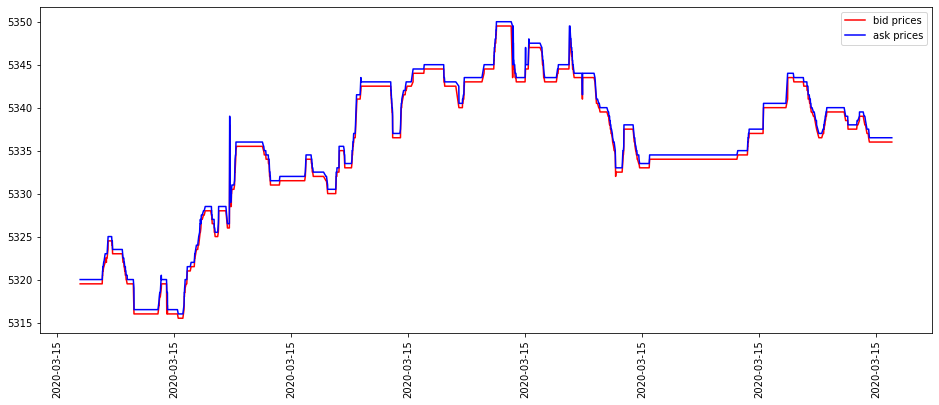

In [6]:

make_plot_orderbook_trade('notebooks/time-sampled/orderbook_1527.csv.gz', 'XBTUSD', 
                          None, orderbook_precomputed=True)